In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import csv
import sys
import heapq
from scipy.stats import poisson 
import seaborn as sns
from scipy.signal import butter, filtfilt,welch
from scipy import signal


In [2]:
def Regular_1(L,Inh):
    L2=L*L
    Matrix=np.zeros((L2,L2),int)
    rng=np.random.default_rng(seed=1)
    for i in range(L):
        for j in range(L):
            ia=i
            ji=j
            id=i
            jd=j
            if ia+1==L:
                ia=-1
            if id==0:
                id=L
            if jd+1==L:
                jd=-1
            if ji==0:
                ji=L
            I=rng.uniform(0.0, 1.0)
            if I<Inh:
                I=0
            else :
                I=1
            Matrix[i*L+j][i*L+jd+1]=1*(2*I-1)## derecha I=0 -1,I=1 1
            I=rng.uniform(0.0, 1.0)
            if I<Inh:
                I=0
            else:
                I=1
            Matrix[i*L+j][i*L+ji-1]=-1*(2*I-1)## izquieda
            I=rng.uniform(0.0, 1.0)
            if I<Inh:
                I=0
            else:
                I=1
            Matrix[i*L+j][(ia+1)*L+j]=-1*(2*I-1)## arriba 
            I=rng.uniform(0.0, 1.0)
            if I<Inh:
                I=0
            else: 
                I=1
            Matrix[i*L+j][(id-1)*L+j]=-1*(2*I-1)# Abajo
    return Matrix

def small_word_Bi(L,P,Inh):
    Matrix=Regular_1(L,Inh)
    rng=np.random.default_rng(seed=1)
    for i in range(L*L):
        for j in range(L*L):
            if Matrix[i][j]==1 and rng.uniform(0.0, 1.0)<P:
                Matrix[i][j]==0
                Matrix[j][i]==0
                jj=rng.integers(0,L*L-1)
                if jj==i or jj==j:
                    jj=rng.integers(0,L*L-1)
                    Matrix[jj][i]=2
                    Matrix[i][jj]=2
                else:
                    Matrix[jj][i]=2
                    Matrix[i][jj]=2
            elif Matrix[i][j]==-1 and rng.uniform(0.0, 1.0)<P:
                Matrix[i][j]==0
                Matrix[j][i]==0
                jj=rng.integers(0,L*L-1)
                if jj==i or jj==j:
                    jj=rng.integers(0,L*L-1)
                    Matrix[jj][i]=-2
                    Matrix[i][jj]=-2
                else:
                    Matrix[jj][i]=-2
                    Matrix[i][jj]=-2
    for i in range(L*L):
        for j in range(L*L):
            if Matrix[i][j]==2:
                Matrix[i][j]=1
                Matrix[j][i]=1
            elif Matrix[i][j]==-2:
                Matrix[i][j]=-1
                Matrix[j][i]=-1
    return Matrix

def Random_bi(L,  P,  Inh):
    matrix=np.zeros((L*L,L*L),int)
    rng=np.random.default_rng(seed=1)
    for i in range(L*L):
        for j in range(L*L):
            I=rng.uniform(0.0,1.0)
            if I<Inh:
                I=0
            else:
                I=1
            if (matrix[i][j]!=1 or matrix[i][j]!=-1) and rng.uniform(0.0,1.0)<P:
            
                matrix[i][j]=-1*(2*I-1)
                matrix[j][i]=-1*(2*I-1)
    return matrix   
    

In [3]:
print(f"a{10} { 10}")

a10 10


In [26]:

class EGG:
    def __init__(self, L, P, inhibidoras,  trest, trelative,  alpha, tmax, type_matrix):
        self.L=L
        self.P=P
        self.inh=inhibidoras
        self.Trest = trest
        self.Trelative = trelative  
        self.tmax=tmax
        self.Alpha = alpha  # Velocity in y direction
        self.L2 = L * L  # Distribution functions
        self.t_matrix=type_matrix
        self.data = np.zeros([tmax,2])  # Lista para almacenar los datos de salida

    def cpp(self):
        # Compilación del programa
        resultado_compilacion = subprocess.run("g++ -O3 main.cpp Matrix_conect.cpp -o main", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        if resultado_compilacion.returncode != 0:
            print("Error durante la compilación:")
            print(resultado_compilacion.stderr)
            return
        
        # Ejecución del programa compilado y captura de salida
        resultado_ejecucion = subprocess.run(f"./main {self.L} {self.P} {self.inh} {self.Trest} {self.Trelative} {self.Alpha} {self.tmax} {self.t_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        
        if resultado_ejecucion.returncode != 0:
            print("Error durante la ejecución:")
            print(resultado_ejecucion.stderr)
        else:
            lines = resultado_ejecucion.stdout.split('\n')
            for i in range (len(lines)-1):
                columns = lines[i].split()
                self.data[i,0]=columns[0]
                self.data[i,1]=columns[1]



In [27]:
#######L,P,inh,trest,trelative,Ch, Time, type
F1=EGG(40,0.01,0.5,1,2,0.1,1000,1)
F1.cpp()
F1.data


array([[   648., -56355.],
       [   634., -59090.],
       [   530., -68315.],
       ...,
       [   195., -96310.],
       [   183., -97870.],
       [   175., -98335.]])

In [49]:

low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 80.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate = 500  # Example sampling rate in Hz

# Creación del filtro Butterworth de banda
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate), high_cutoff / (0.5 * sampling_rate)], btype='band')

# Carga de datos adicionales
data = F1.data
filtered_data_a = signal.filtfilt(b, a, data[30:, 0])
filtered_data_b = signal.filtfilt(b, a, data[30:, 1])

# Parámetros para el método de Welch
fs = 200  # Sampling rate
nperseg = int(fs * 4)  # Segment length
noverlap = int(fs * 2)  # Overlap between segments

# Cálculo de la PSD usando el método de Welch
frequencies_a, psd_a = signal.welch(filtered_data_a, fs, nperseg=nperseg, noverlap=noverlap)
alplitud_a = np.zeros_like(psd_a)
# Conversion a decibelios
for i in range(len(frequencies_a)):
    alplitud_a[i] = 10 * np.log10(psd_a[i])

frequencies_b, psd_b = signal.welch(filtered_data_b, fs, nperseg=nperseg, noverlap=noverlap)
alplitud_b = np.zeros_like(psd_b)
# Conversion a decibelios
for i in range(len(frequencies_b)):
    alplitud_b[i] = 10 * np.log10(psd_b[i])

reales = np.loadtxt("F7_MNE.txt")*1e6
f_reales, psd_reales = signal.welch(reales, fs, nperseg=nperseg)
alplitud_rea = np.zeros_like(psd_reales)
# Conversion a decibelios
for i in range(len(f_reales)):
    alplitud_rea[i] = 10 * np.log10(psd_reales[i])


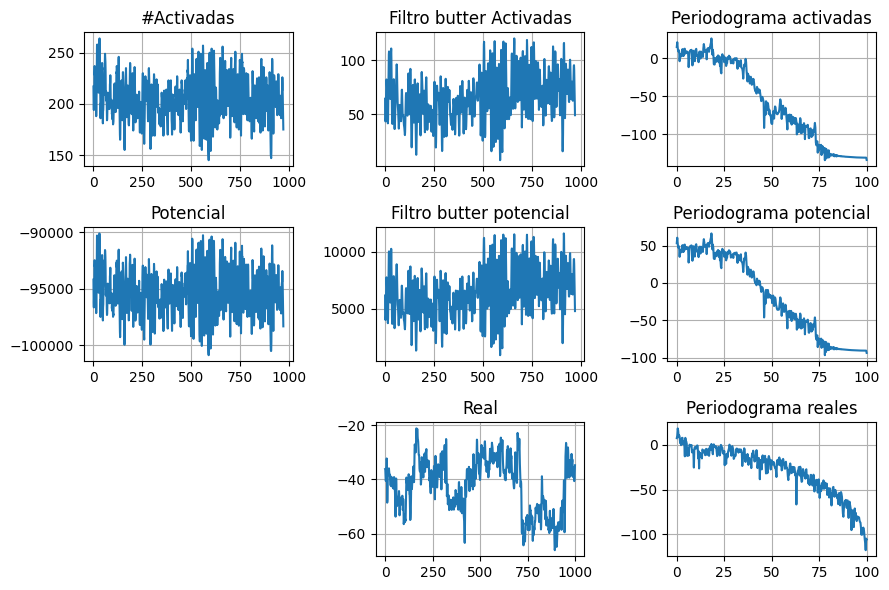

In [50]:
fig = plt.figure(figsize=(9, 6),num=f"L{F1.L}p{F1.P}in{F1.inh}tr{F1.Trest}te{F1.Trelative}")
    
plt.subplot(3, 3, 1)
plt.plot(data[30:,0], label='# Activadas')
plt.title("#Activadas")
plt.grid()
    
plt.subplot(3, 3, 4)
plt.plot(data[30:,1], label='Potencial')
plt.title("Potencial")
plt.grid()
    

plt.subplot(3, 3, 2)
plt.plot(filtered_data_a, label='Filtro butter Activadas')
plt.title("Filtro butter Activadas")
plt.grid()


plt.subplot(3, 3, 5)
plt.plot(filtered_data_b, label='Filtro butter potencial')
plt.title("Filtro butter potencial")
plt.grid()
    
plt.subplot(3, 3, 3)
plt.plot(frequencies_a, alplitud_a, label='Potencial')
plt.title("Periodograma activadas")
plt.grid()
    
plt.subplot(3, 3, 6)
plt.plot(frequencies_b, alplitud_b, label='Potencial')
plt.title("Periodograma potencial")
plt.grid()
    
plt.subplot(3, 3, 8)
plt.plot(reales, label='reales')
plt.title("Real")
plt.grid()
    
plt.subplot(3, 3, 9)
plt.plot(f_reales, alplitud_rea, label='real')
plt.title("Periodograma reales")
plt.grid()
    

plt.tight_layout()
